# **Overview**

The primary objective is to develop a machine learning model that predicts loan eligibility in real-time. By leveraging applicant data from online forms, the system automates decision-making to improve efficiency and reduce manual processing

#### **Workflow**

1. [Data Cleaning](#Data-Cleaning)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. Feature Engineering
4. Model Training
5. Evaluation
6. 

In [11]:
# Uncomment the line below to install the dependencies
# !pip install -r requirements.txt

In [12]:
# Loading necessary packages abd libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# Load the datasets
df_train = pd.read_csv('loan_train.csv')
df_final = pd.read_csv('loan_test.csv')

print(f"Train Data has: {df_train.shape[0]} Rows, {df_train.shape[1]} Columns")
print(f"Test Data has: {df_final.shape[0]} Rows, {df_final.shape[1]} Columns")

Train Data has: 614 Rows, 13 Columns
Test Data has: 367 Rows, 12 Columns


In [14]:
df_train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [16]:
print("Missing values before cleaning:")
print(df_train.isnull().sum())

Missing values before cleaning:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [17]:
# Get Numerical columns (int and float)
num_cols = df_train.select_dtypes(include=['number']).columns.tolist()

# Get Categorical columns (object and category)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [18]:
# Dropping the 'Loan_Id' and 'Loan_Status' from the list of categorical feature
cat_cols = cat_cols[1:7]
print(cat_cols)

num_cols = num_cols[:-1]
print(num_cols)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


### Data Cleaning

In [19]:
# Function to fill missing values

missing_value_handler_pipeline = ColumnTransformer(transformers=[('cat_mode', SimpleImputer(strategy='most_frequent'), cat_cols),
    ('num_median', SimpleImputer(strategy='median'), num_cols),
    ('num_mode', SimpleImputer(strategy='most_frequent'), ['Credit_History'])
])

cleaned_df_data = missing_value_handler_pipeline.fit_transform(df_train)
feature_names = cat_cols + num_cols + ['Credit_History']

# Convert back to DataFrame for visibility
cleaned_df_train = pd.DataFrame(cleaned_df_data, columns=feature_names)
cleaned_df_train.index = df_train.index
cleaned_df_train['Loan_ID'] = df_train['Loan_ID']
cleaned_df_train['Loan_Status'] = df_train['Loan_Status']
cleaned_df_train.head(10)

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Loan_Status
0,Male,No,0,Graduate,No,Urban,5849.0,0.0,128.0,360.0,1.0,LP001002,Y
1,Male,Yes,1,Graduate,No,Rural,4583.0,1508.0,128.0,360.0,1.0,LP001003,N
2,Male,Yes,0,Graduate,Yes,Urban,3000.0,0.0,66.0,360.0,1.0,LP001005,Y
3,Male,Yes,0,Not Graduate,No,Urban,2583.0,2358.0,120.0,360.0,1.0,LP001006,Y
4,Male,No,0,Graduate,No,Urban,6000.0,0.0,141.0,360.0,1.0,LP001008,Y
5,Male,Yes,2,Graduate,Yes,Urban,5417.0,4196.0,267.0,360.0,1.0,LP001011,Y
6,Male,Yes,0,Not Graduate,No,Urban,2333.0,1516.0,95.0,360.0,1.0,LP001013,Y
7,Male,Yes,3+,Graduate,No,Semiurban,3036.0,2504.0,158.0,360.0,0.0,LP001014,N
8,Male,Yes,2,Graduate,No,Urban,4006.0,1526.0,168.0,360.0,1.0,LP001018,Y
9,Male,Yes,1,Graduate,No,Semiurban,12841.0,10968.0,349.0,360.0,1.0,LP001020,N


In [20]:
print("Missing values after cleaning:")
print(cleaned_df_train.isnull().sum())

Missing values after cleaning:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Property_Area        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Loan_ID              0
Loan_Status          0
dtype: int64


### Exploratory Data Analysis

Target Variable Distribution

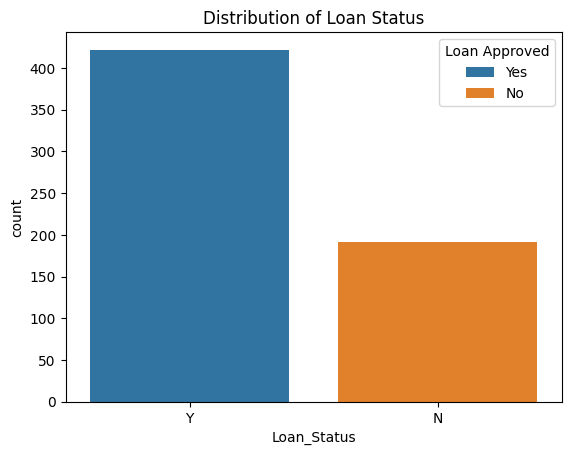

In [ ]:
ax = sns.countplot(data=cleaned_df_train, x='Loan_Status', hue='Loan_Status')
plt.title('Distribution of Loan Status')
plt.legend(title='Loan Approved', labels=['Yes', 'No'])
plt.show()

Calculating the correlation matrix for all numerical columns.

In [ ]:
def feature_engineering(df):
    # 1. Create Total Income
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

    # 2. Log Transformation (Normalization)
    df['LoanAmount_Log'] = np.log(df['LoanAmount'])
    df['Total_Income_Log'] = np.log(df['Total_Income'])

    # 3. Drop old raw columns & ID
    cols_to_drop = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income']
    if 'Loan_ID' in df.columns:
        cols_to_drop.append('Loan_ID')
        
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    return df

# Apply to both
df_train = feature_engineering(df_train)
df_final = feature_engineering(df_final)

print("Feature Engineering Complete.")
display(df_train.head())

In [ ]:
df_train['Gender'].unique()

In [ ]:
# Initialize Encoder
le = LabelEncoder()

cols_to_encode = ['Gender', 'Married', 'Dependents', 'Education',
                  'Self_Employed', 'Property_Area']

# Encode Train
for col in cols_to_encode:
    df_train[col] = le.fit_transform(df_train[col])

# Encode Target specifically
df_train['Loan_Status'] = le.fit_transform(df_train['Loan_Status'])

# Encode Test (using same logic)
for col in cols_to_encode:
    df_final[col] = le.fit_transform(df_final[col])

print("Data encoded successfully!")

In [ ]:
df_train['Gender'].unique()

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df_train)
plt.title('Distribution of Loan Status (Target)')
plt.show()

In [ ]:
# Define Features (X) and Target (y)
X = df_train.drop('Loan_Status', axis=1)
y = df_train['Loan_Status']

# Split 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)

In [ ]:
# Tuned Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,        # More trees
    max_depth=10,            # Prevent overfitting
    class_weight='balanced', # Improve Recall for 'Rejected' loans
    random_state=42
)

rf_model.fit(X_train, y_train)
print("Tuned Model Trained.")

In [ ]:
# Predictions on Validation Set
y_pred = rf_model.predict(X_val)

# Accuracy
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Visual Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
joblib.dump(rf_model, 'loan_model.joblib')
print("Model saved as 'loan_model.joblib'")

In [ ]:
# Predict on the real test file
final_predictions = rf_model.predict(df_final)

# We need the original IDs for submission. 
# Since we dropped them from df_test, we read the original file again just to get IDs.
test_ids = pd.read_csv('loan_test.csv')['Loan_ID']

# Create Submission DataFrame
submission = pd.DataFrame({
    'Loan_ID': test_ids,
    'Loan_Status': final_predictions
})

# Convert 1/0 back to Y/N
submission['Loan_Status'] = submission['Loan_Status'].map({1: 'Y', 0: 'N'})

# Save
submission.to_csv('final_submission.csv', index=False)
print("Final predictions saved to 'final_submission.csv'")
print(submission.head())